In [2]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [2]:
conc1=xr.open_dataarray('/home/jvalenti/MOAD/results/Fraser_nobiof_prob.nc')
conc=xr.open_dataarray('/home/jvalenti/MOAD/results/Fraser_biof_prob.nc')
conc2=xr.open_dataarray('/home/jvalenti/MOAD/results/Turb_off_prob.nc')
conc3=xr.open_dataarray('/home/jvalenti/MOAD/results/No_float_prob.nc')
conc4=xr.open_dataarray('/home/jvalenti/MOAD/results/No_float-noturb_prob.nc')

local = 0 #Set to 0 when working on server
paths = path(local)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [3]:
def mapanimation(file,clon,clat,fps=1,local=1):
    
    def update(frame): 
        plt.clf()
        ax = plt.axes(xlim=(-125,-122.5),ylim=(48.5,49.7))
        t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
        t.set_text('')
        tstamp = file.time[frame].values.astype('datetime64[s]').astype(datetime)
        #print(tstamp)
        t.set_text(tstamp)
        ss = []
        ss.append(ax.contourf(coords.nav_lon, coords.nav_lat, file[frame,:,:],levels=np.arange(1,30,2),cmap=cmocean.cm.dense))
        ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
        ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
        ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
        ax.grid()
        axs.set_aspect(1/np.sin(np.deg2rad(49)))
        plt.ylabel('Latitude',fontsize=16)
        plt.xlabel('Longitude',fontsize=16)
        return fig
        
    #scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)
    #sed= {0: "w", 1: "k"}


    return animation.FuncAnimation(fig, update, frames=np.arange(0,file.shape[0],fps))

In [4]:
z = mask.gdepw_0[0,:,240,340]
# cend=conc*0.1*(2118/5)*(2*3600/2.6e6)
# cend1=conc1*0.1*(2118/5)*(2*3600/2.6e6)
# cend2=conc2*0.1*(2118/5)*(2*3600/2.6e6)
# cend3=conc3*0.1*(2118/5)*(2*3600/2.6e6)


# fig = plt.figure(figsize=(19, 8))
# axs = plt.axes(xlim=(-123.25,-122.8),ylim=(49,49.25))
# #axs=plt.axes(xlim=(-125,-122.5),ylim=(48.5,49.7))

# levels = np.linspace(1,800,50)

# colors = list(cmocean.cm.dense(np.linspace(0,1,len(levels)-1)))
# colors[-1] = "red"
# cmap = matplotlib.colors.ListedColormap(colors,"", len(colors))



# #axs.contourf(coords.nav_lon, coords.nav_lat, 10*mask.mbathy[0,:,:],levels=np.arange(0,400,10),cmap=cmocean.cm.deep,alpha=1)
# a=axs.contourf(coords.nav_lon, coords.nav_lat, cend2[:,:,0],levels=np.arange(1,150,5),cmap=cmap,extend='max')
# #axs.scatter(frs_lon,frs_lat)
# axs.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')

# #axs.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
# plt.colorbar(a)

# axs.set_aspect(1/np.sin(np.deg2rad(49)))

In [5]:
def get_area(latmin,latmax,lonmin,lonmax, conc):
    jjii = xr.open_dataset('~/MOAD/grid/grid/grid_from_lat_lon_mask999.nc')
    j = [jjii.jj.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    i = [jjii.ii.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    j.append(jjii.jj.sel(lats=latmin, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmin, lons=lonmax, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmin, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmin, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmax, method='nearest').item())
    a=[min(j),max(j),min(i),max(i)]
    Len = (a[1]-a[0])*(a[3]-a[2])
    SD = []
    Mean = []
    for ki in range(len(z)):
        values = []
        for j in range(a[0],a[1],1):
            for i in range(a[2],a[3],1):
                values.append(conc[j,i,ki])
        values = np.array(values)
        Mean.append(np.mean(values))
        #print(Mean)
        SD.append(np.std(values)/np.sqrt(Len))
        #print(SD)
    return Mean,SD

In [6]:
def MP_measure(ax,conc):

    Fraser_MP,Fraser_SE=get_area(49.1,49.13,-123.2,-123.16,conc)
    #SoG_MP,SoG_SE =get_area(48.5,49.5,-124.2,-123.2,conc)
    #Lori_MP,Lori_SE =get_area(49.1,49.36,-123.3,-123.2,conc)
    #ax.errorbar(Lori_MP, -z, xerr = Lori_SE,label="Lori's Sample")
    ax.errorbar(Fraser_MP, -z, xerr = Fraser_SE,label="Fraser Sample")
    #ax.errorbar(SoG_MP, -z, xerr = SoG_SE,label="SoG test")
    ax.legend()
    ax.set_ylim(-20,0)

Text(0.5, 1.0, 'No floating no turbulent mixing')

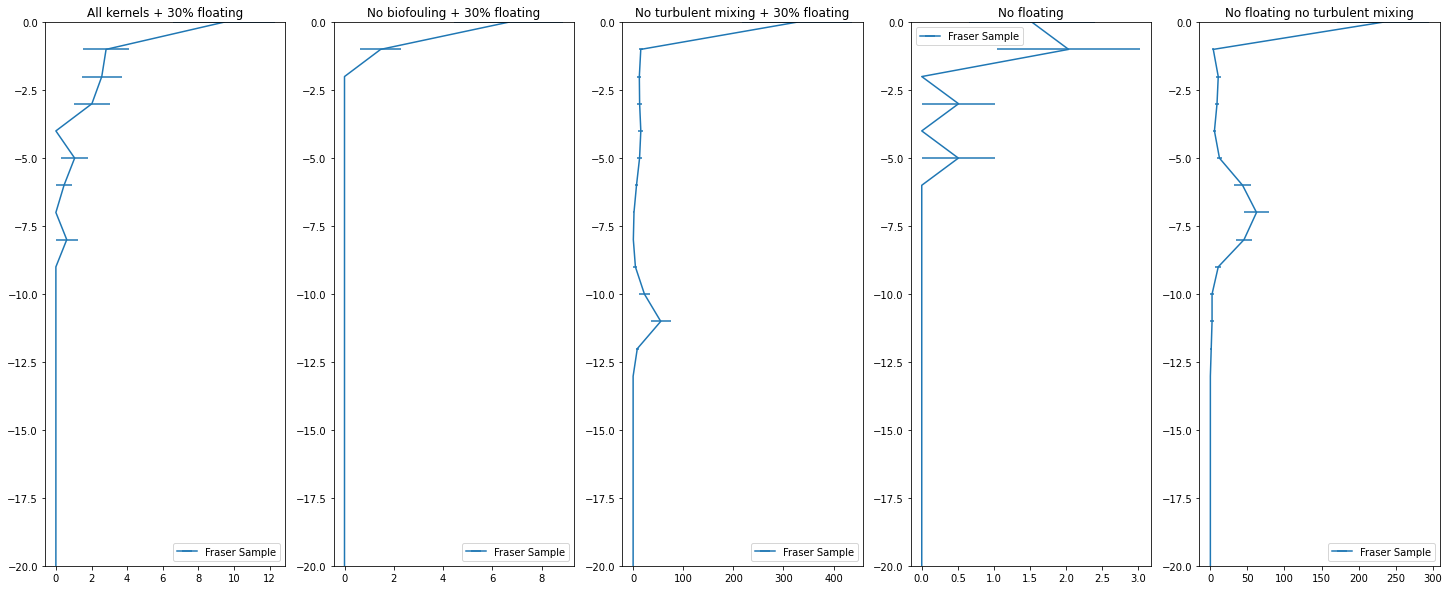

In [7]:
fig,axs=plt.subplots(1,5,figsize=(25,10))
MP_measure(axs[0],conc)
MP_measure(axs[1],conc1)
MP_measure(axs[2],conc2)
MP_measure(axs[3],conc3)
MP_measure(axs[4],conc4)
axs[0].set_title('All kernels + 30% floating')
axs[1].set_title('No biofouling + 30% floating')
axs[2].set_title('No turbulent mixing + 30% floating')
axs[3].set_title('No floating')
axs[4].set_title('No floating no turbulent mixing')

In [3]:
dW = np.random.normalvariate(0, sqrt(particle.dt)) 
wprime = Kzdz + (sqrt(2*Kz)*dW)/particle.dt 
dzp = wprime*particle.dt

AttributeError: module 'numpy.random' has no attribute 'normalvariate'

In [8]:
# fig = plt.figure(figsize=(19, 8))
# anim = mapanimation(conc,clon,clat,fps=1)
# f = r"/home/jvalenti/MOAD/animations/Fraser2.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [9]:
#  with open(f,'rb') as anim:
#     display(Image(anim.read()))